In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

Matplotlib is building the font cache; this may take a moment.


In [4]:
# Suppress warnings
warnings.filterwarnings('ignore')

In [5]:
# Load the dataset
df = pd.read_csv('temperature_data.csv')

In [6]:
df['to_timestamp'] = pd.to_datetime(df['to_timestamp'])

In [7]:
start_date = pd.to_datetime('2023-01-01')
end_date = pd.to_datetime('2023-12-31')

In [8]:
df = df[(df['to_timestamp'] >= start_date) & (df['to_timestamp'] <= end_date)]

In [9]:
if 'agg_temp' in df.columns:
    df['agg_temp'] = df['agg_temp'].apply(lambda x: x / 10 if x == 932 else x)

In [10]:
temp_columns = [col for col in df.columns if col.endswith('temp')]

In [11]:
selected_columns = ['to_timestamp'] + temp_columns

In [12]:
temp_df = df[selected_columns]

In [13]:
temp_df.drop_duplicates(inplace=True)

In [14]:
temp_df.sort_values('to_timestamp', inplace=True)

In [15]:
temp_df.fillna(method='ffill', inplace=True)

In [16]:
for col in temp_columns:
    for lag in range(1, 7):  # Using 6 lags as an example
        temp_df[f'{col}_lag_{lag}'] = temp_df[col].shift(lag)

In [17]:
temp_df.dropna(inplace=True)

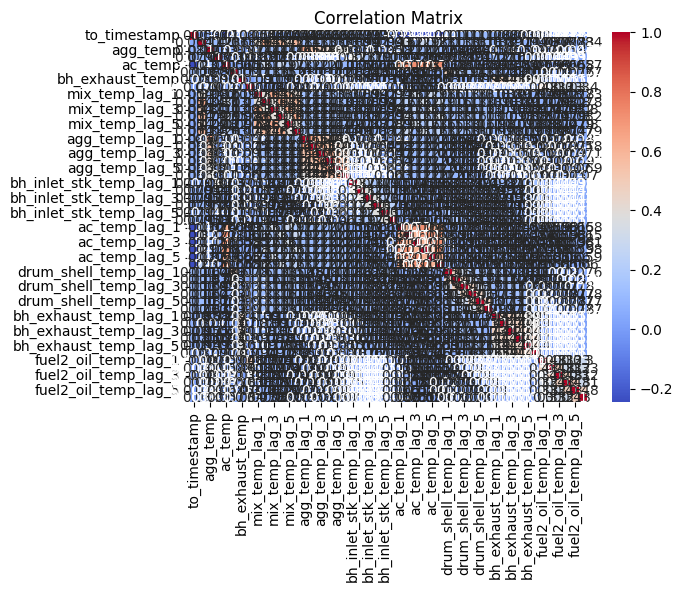

In [18]:
correlation_matrix = temp_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [19]:
# Initialize a dictionary to store models, predictions, and performance metrics
models = {}
predictions = {}
mse_scores = {}

In [20]:
model_dict = {
    'XGBoost': XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

In [21]:
for temp_col in temp_columns:
    print(f'Processing {temp_col}...')
    
    # Define features and target for the current temperature column
    features = [col for col in temp_df.columns if 'lag' in col and col.startswith(temp_col)]
    target = temp_col

    # Split the data into training and testing sets
    X = temp_df[features]
    y = temp_df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for model_name, model in model_dict.items():
        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        print(f'Mean Squared Error for {temp_col} using {model_name}: {mse}')

        # Store the model and MSE in the dictionaries
        models[f'{temp_col}_{model_name}'] = model
        mse_scores[f'{temp_col}_{model_name}'] = mse

        # Use the last known values to make a prediction for the next ten minutes (using the best model)
        if model_name == 'XGBoost':
            latest_data = temp_df.tail(1)

            # Prepare the lagged features for the new data point
            new_data = latest_data.copy()
            for lag in range(1, 7):
                new_data[f'{temp_col}_lag_{lag}'] = temp_df[temp_col].shift(lag).tail(1).values[0]

            # Ensure there are no NaN values in the new_data
            new_data.fillna(method='ffill', inplace=True)

            # Predict the temperature for the next ten minutes
            next_temp_pred = model.predict(new_data[features])
            predictions[temp_col] = next_temp_pred[0]
            print(f'Predicted {temp_col} for the next ten minutes using {model_name}: {next_temp_pred[0]}')


Processing mix_temp...
Mean Squared Error for mix_temp using XGBoost: 619.6791970382633
Predicted mix_temp for the next ten minutes using XGBoost: 57.78240203857422
Mean Squared Error for mix_temp using Linear Regression: 677.1743024074821
Mean Squared Error for mix_temp using Random Forest: 574.4530954371787
Processing agg_temp...
Mean Squared Error for agg_temp using XGBoost: 1790.2930047348705
Predicted agg_temp for the next ten minutes using XGBoost: 93.21306610107422
Mean Squared Error for agg_temp using Linear Regression: 1391.3220015499132
Mean Squared Error for agg_temp using Random Forest: 1409.5728242301113
Processing bh_inlet_stk_temp...
Mean Squared Error for bh_inlet_stk_temp using XGBoost: 62257.23221188422
Predicted bh_inlet_stk_temp for the next ten minutes using XGBoost: 53.583499908447266
Mean Squared Error for bh_inlet_stk_temp using Linear Regression: 45161.10316850387
Mean Squared Error for bh_inlet_stk_temp using Random Forest: 47667.36363339419
Processing ac_temp

In [22]:
# Display all predictions
print("Predictions for the next ten minutes for each temperature column:")
for temp_col, pred in predictions.items():
    print(f'{temp_col}: {pred}')

Predictions for the next ten minutes for each temperature column:
mix_temp: 57.78240203857422
agg_temp: 93.21306610107422
bh_inlet_stk_temp: 53.583499908447266
ac_temp: 99.72106170654297
drum_shell_temp: 58.86484146118164
bh_exhaust_temp: 47.821407318115234
fuel2_oil_temp: 47.53602600097656


In [23]:
# Display MSE scores for comparison
print("Model performance comparison (MSE):")
for key, mse in mse_scores.items():
    print(f'{key}: {mse}')


Model performance comparison (MSE):
mix_temp_XGBoost: 619.6791970382633
mix_temp_Linear Regression: 677.1743024074821
mix_temp_Random Forest: 574.4530954371787
agg_temp_XGBoost: 1790.2930047348705
agg_temp_Linear Regression: 1391.3220015499132
agg_temp_Random Forest: 1409.5728242301113
bh_inlet_stk_temp_XGBoost: 62257.23221188422
bh_inlet_stk_temp_Linear Regression: 45161.10316850387
bh_inlet_stk_temp_Random Forest: 47667.36363339419
ac_temp_XGBoost: 749.6955015832926
ac_temp_Linear Regression: 767.8839951669942
ac_temp_Random Forest: 696.5201210538559
drum_shell_temp_XGBoost: 78755.8559609012
drum_shell_temp_Linear Regression: 41994.4864251312
drum_shell_temp_Random Forest: 52735.84305228096
bh_exhaust_temp_XGBoost: 51673.013356247706
bh_exhaust_temp_Linear Regression: 39087.019238541965
bh_exhaust_temp_Random Forest: 39950.5573314314
fuel2_oil_temp_XGBoost: 21304.929875808415
fuel2_oil_temp_Linear Regression: 17800.17664980213
fuel2_oil_temp_Random Forest: 19190.10435325937
